In [15]:
import os
import numpy as np
import random
from IPython.display import HTML

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

from nltk.corpus import cmudict

In [30]:
def syllables(word):
    #referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

In [33]:
d = cmudict.dict()
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return [syllables(word)]

In [2]:
text = open(os.path.join(os.getcwd(), 'data/all_poems.txt')).read()

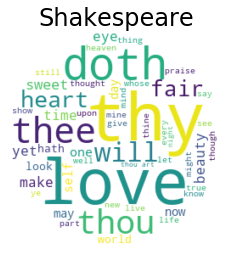

In [3]:
wordcloud = text_to_wordcloud(text, title='Shakespeare')

In [4]:
syl = {}
f = open('./data/Syllable_dictionary.txt', 'r')
for line in f:
    new_line = line[:-1]
    line_lst = list(new_line.split(" "))
    syl[line_lst[0]] = line_lst[1:]
f.close()

In [5]:
obs, obs_map = parse_observations(text)
emission_map = {v: k for k, v in obs_map.items()}

In [6]:
def get_obs(O, state):
    rand_var = random.uniform(0, 1)
    next_obs = 0

    while rand_var > 0:
        rand_var -= O[state][next_obs]
        next_obs += 1

    next_obs -= 1
    return next_obs

In [24]:
def convert_list(lst):
    s = [str(i) for i in lst]
    return s

In [28]:
def generate_line(hmm, st):
    # get the transition and emission matrices
    A = hmm.A
    O = hmm.O
    L = hmm.L
    # get start state
    state = st
    words = []
    syllables = 0
    # while haven't finished line
    while syllables < 10:
        # Sample next observation.
        next_obs = get_obs(O, state)
        m = len(words)
        added = False
        
        # add the word to line
        word = emission_map[next_obs]
        try:
            syls = syl[word]
        except KeyError:
            syls = convert_list(nsyl(word))
        if syls[0][0] == 'E':
            n = int(syls[0][1])
            if n + syllables == 10:
                words.append(word)
                syllables += n
                added = True
            else:
                n = int(syls[1])
                if n + syllables <= 10:
                    words.append(word)
                    syllables += n
                    added = True
        else:
            n = int(syls[0])
            if n + syllables <= 10:
                words.append(word)
                syllables += n
                added = True
        
        # Sample next state if word added
        if added:
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state
    
    return ' '.join(words), state

In [ ]:
hmms = []

In [36]:
# train HMMs
# tried several number of states
# training takes very long for >20 states but should achieve better results
num_states = [20]

for num in num_states:
    print("Training HMM with %d states for 100 iterations" % num)
    hmm = unsupervised_HMM(obs, num, 100)
    hmms.append(hmm)
    print("================================================")

Training HMM with 20 states for 100 iterations
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


In [9]:
def generate_sonnet(hmm):
    state = np.random.choice(hmm.L)
    lines = []
    for i in range(14):
        line, state = generate_line(hmm, state)
        line = line.capitalize()
        if i == 13:
            line += '.'
        elif i % 4 == 3:
            line += ':'
        else:
            line += ','
        lines.append(line)
    
    return lines

In [38]:
for i in range(len(hmms)):
    print("Sonnet with HMM %d\n" % (10 + 10 * i))
    print("===============================================")
    sonnet = generate_sonnet(hmms[i])
    for line in sonnet:
        print(line, end='\n')
    print("===============================================")

Sonnet with HMM 10

O pure wander qualify forlorn your,
Seasons' should suggest that through me when chaste,
Most to though but with therefore adjunct you,
Truth thee heaven wherefore heavenly would this lurk:
Of i alchemy day that a see which,
Was never more sweet my or out i hope,
Sweet with nymphs part and her janus' peace but,
Your that durst cuckoo is fortune am like:
In discontent thence therefore did sweet with,
Whom how and this good aside triumph tears,
Oaths' muse my feeding or the wilt wish course,
Living love where old gardens call sea my:
Injurious she fill you to after day,
Says on never strange translated their sweet.
Sonnet with HMM 20

Which a wound process at moon your office,
Thee doth thou and in fiery black to thine,
As the means but your o wouldst direct did,
More scope it find no with his wide to die:
Do thou to such hath whose which adorn it,
From that and ransoms am thou what with doth,
Not if if mistress' where and should old floor,
Yet the fair the warmed bet

In [41]:
sonnet = generate_sonnet(hmms[1])
for line in sonnet:
    print(line, end='\n')

Time of spot skilled captive till she things clouds,
One of the heard spring this his of many vice,
In reckoning old so so which by new as,
Amiss art not baleful kind but grown sith:
Here they me that still than careless hate but,
Past should thee my wailing no to unquiet,
History yet him ye strains captive speed,
Shall journey with else i then that beauty's:
Know and approve no better pent prove ward,
As rolling their commence to your day bud,
Eyes wilt both not rest o'ercharged whom seeing,
Beloved with assure built deep for our dull:
Bound i faithful lies such for your gay of,
Most general woods which her absent not due.


In [42]:
# write poem to file
with open('./poems/spenser_hmm.txt', 'w') as f:
    for line in sonnet:
        f.write("%s\n" % line)